In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os
import warnings
import glob
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.signal import peak_prominences
from scipy.stats.mstats import chisquare, kstest
from scipy.signal import find_peaks

import PySimpleGUI as sg
from bokeh.plotting import figure, show, output_file
from bokeh.models import Span, ColumnDataSource, Slider, CustomJS, Button, Range1d
from bokeh.io import output_notebook, curdoc
from bokeh.layouts import column, row
from bokeh.events import ButtonClick

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

from astropy.io import fits
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
from astropy.table import Table, vstack, hstack, join
from astropy.modeling import models
from astropy.modeling.fitting import LevMarLSQFitter
from specutils.fitting import find_lines_threshold, find_lines_derivative, fit_lines
from specutils.manipulation import noise_region_uncertainty, trapezoid_smooth, box_smooth, gaussian_smooth, median_smooth
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import NDUncertainty

from astroquery.simbad import Simbad
from astroquery.nist import Nist
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier
from astroquery.mast import Observations

%matplotlib inline
# output_notebook()


## Where should results be saved to?

analysispath = '/Users/isabelkain/Desktop/GALEX/analysis'
datapath = '/Volumes/Seagate/seagate_backup/GALEX/data'
# datapath = '/Users/isabelkain/Desktop/GALEX/data'


In [2]:
def redshift_correction(wavelengths_observed, z):
    '''
    Finds amount by which stellar emission is redshifted, and subtract this from stellar spectrum.
    Input:
    wavelengths_observed: observed wavelengths of spectrum (Angstroms)
    z: redshift of star
    
    Returns:
    wavelengths_emitted: emitted wavelengths of spectrum (Angstroms)
    '''
    
    wavelengths_emitted = wavelengths_observed / (1 + z)
    return wavelengths_emitted


def blackbody(wavelengths, Teff):
    '''
    Returns blackbody continuum for an object at Teff (K)
    Inputs:
    wavelengths [arr]: (Angstroms)
    Teff [scalar]: effective temperature (K)
    
    Returns:
    B [arr]: blackbody continuum for Teff (unitless)
    '''
    
    wav = wavelengths * angstrom2meter * u.m
    Teff = Teff * u.K
    
    B = (2. * const.h * const.c**2) / (wav**5.) / ( np.exp( (const.h * const.c) / (wav * const.k_B * Teff) ) - 1. )
    
    return (B / B.max()).value


def fitBB_fixedTeff(wavelengths, Teff, a, b):
    '''
    Scale blackbody continuum emission.
    Input:
    wavelengths [arr]: spectrum wavelengths (Angstroms)
    Teff [scalar]: effective temperature of star (K)
    a, b: scaling factors to be optimized by curve_fit
    '''
    return a * blackbody(wavelengths, Teff) + b


def fitBB_fitTeff(wavelengths, Teff, a, b):
    '''
    Fit blackbody emission to spectrum continuum. 
    Input:
    wavelengths [arr]: spectrum wavelengths (Angstroms)
    Teff [scalar]: effective temperature of star (K) (will be optimized by curve_fit)
    a, b: scaling factors to be optimized by curve_fit
    
    Returns:
    -- [arr]: blackbody continuum curve
    '''
    
    wav = wavelengths * angstrom2meter * u.m
    Teff = Teff * u.K
    
    B = (2. * const.h * const.c**2) / (wav**5.) / ( np.exp( (const.h * const.c) / (wav * const.k_B * Teff) ) - 1. )

    return a * (B / B.max()).value + b


def MAD(array):
    '''
    Return the median absolute deviation (MAD) of array
    Input:
    array [arr]: 1xn array of values
    
    Returns:
    -- [scalar]: MAD
    '''
    med = np.median(array)
    return np.median([abs(num - med) for num in array])


def gaussian(x, a, b, c):
    '''
    a: amplitude of peak
    b: position of peak
    c: standard deviation
    '''
    return a * np.exp( -(x - b)**2 / (2*c**2) )


##########################
## Define helper functions
##########################

angstrom2meter = 10**-10
joules2ergs = 10**7

# Read in data

In [3]:
table = Table.read(f'{analysispath}/dataset.ecsv')

table[:5]

main_id,main_type,sp_type,obs_id,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method,Peaks verified,Peaks identified,Rerun verification,Rerun identification,IUE type
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,,,,,,
str23,str19,str18,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5,bool,bool,bool,bool,str34
* gam Mic,Star,G8III,swp54894,315.3224724693,-32.2577449364,315.322853,-32.257566,315.3227519696,-32.2577659353,49875.41707,49875.45873,3599.844,IUE Survey of X-Ray Selected Late-Type Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/54000/gif/swp54894.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp54894mxlo_vo.fits,315.444385,-32.448868,157.0,157.0,17.2783,0.0402,12.2301,0.0027,0,2,0,0,445.323,16.4837,46554.0,117.279,A,2007A&A...474..653V,*|**|IR|UV|X,17.5,0.36,5.84e-05,1.2e-06,14.24,0.26,-1.73,0.41,5.529,4.654,--,3.15,2.713,2.596,--,--,--,--,--,5.529,0.009,Vega,D,--,--,,--,--,--,,--,3.15,0.010,Vega,B,2.596,0.010,Vega,B,* gam Mic,5310,3.0000,-0.010,--,--,--,--,0,--,G8III,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,14.240,2,0.26,A,68.2929,pc,-2.3161,2.3161,paral,True,False,False,False,G III-I
HD 2454,PM*,F5VSr,swp55292,7.083429661399975,10.1900690724,7.083387,10.189901,7.0835103411,10.1898049067,49914.07061,49914.09145,1799.522,The White Dwarf Luminosity Function in F-K Binaries,http://archive.stsci.edu/browse/previews/iue/mx/swp/55000/gif/swp55292.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp55292mxlo_vo.fits,7.182728,10.038623,215.0,215.0,15.2804,0.0112,11.7018,0.0018,0,2,0,0,2804.53003,29.043,75731.89844,123.038,A,2020yCat.1350....0G,*|IR|PM*|Ro*|UV,-8.62,0.2,-2.88e-05,7e-07,26.2526,0.057,42.022,-180.181,6.47,--,5.8,5.201,5.057,4.942,--,--,--,--,--,6.47,--,,--,5.8,--,Vega,E,--,--,,--,5.201,0.037,Vega,C,4.942,0.020,Vega,C,HD 2454,6501,4.1100,-0.350,--,--,--,--,0,--,F5VSr,C,HighPM*,ROT,--,--,--,--,--,--,--,--,3.000000,--,--,26.253,3,0.057,A,38.0910,pc,-0.0827,0.0827,paral,True,False,False,False,F3-F9
* ksi01 Lib,PM*,K0III,swp55297,223.59536528340004,-11.8983649295,223.595816,-11.898603,223.5953088134,-11.8983503771,49914.87583,49914.92235,4019.145,--,http://archive.stsci.edu/browse/previews/iue/mx/swp/55000/gif/swp55297.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp55297mxlo_vo.fits,223.657823,-11.517354,89.0,90.0,20.5984,0.3548,13.6332,0.0069,256,0,0,0,20.9243,6.83601,12785.2002,81.2597

In [21]:
## Identify which spectrum is getting reduced, either by swpid or star name

# ## Choose by IUE id number
# swpid = 'swp51734'                                              ## SWP ID, e.g. swp54894
# tblrow = table[table['obs_id']==swpid][0]
# starname = tblrow['main_id'][0]                                 ## Star name, e.g. * gam Mic
# objname = starname.replace(' ','')                              ## No-spaces star name, e.g. *gamMic

## Choose by star name
starname = '* gam Mic'                                          ## Star name, e.g. * gam Mic
tblrow = table[table['main_id']==starname][0]
swpid = tblrow['obs_id']                                        ## SWP ID, e.g. swp54894
objname = starname.replace(' ','')                              ## No-spaces star name, e.g. *gamMic


print(starname, swpid, objname)
tblrow


* gam Mic swp54894 *gamMic


main_id,main_type,sp_type,obs_id,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method,Peaks verified,Peaks identified,Rerun verification,Rerun identification,IUE type
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,,,,,,
str23,str19,str18,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5,bool,bool,bool,bool,str34
* gam Mic,Star,G8III,swp54894,315.3224724693,-32.2577449364,315.322853,-32.257566,315.3227519696,-32.2577659353,49875.41707,49875.45873,3599.844,IUE Survey of X-Ray Selected Late-Type Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/54000/gif/swp54894.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp54894mxlo_vo.fits,315.444385,-32.448868,157.0,157.0,17.2783,0.0402,12.2301,0.0027,0,2,0,0,445.323,16.4837,46554.0,117.279,A,2007A&A...474..653V,*|**|IR|UV|X,17.5,0.36,5.84e-05,1.2e-06,14.24,0.26,-1.73,0.41,5.529,4.654,--,3.15,2.713,2.596,--,--,--,--,--,5.529,0.009,Vega,D,--,--,,--,--,--,,--,3.15,0.010,Vega,B,2.596,0.010,Vega,B,* gam Mic,5310,3.0000,-0.010,--,--,--,--,0,--,G8III,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,14.240,2,0.26,A,68.2929,pc,-2.3161,2.3161,paral,True,False,False,False,G III-I


# Collect info, apply redshift and BB corrections

In [22]:
## Open FITS file

hdul = fits.open(f'/Users/isabelkain/Desktop/GALEX/data/{swpid}.fits')


## Collect exposure information from header

# target = hdul[1].header['OBJECT']       # target name
spclass = hdul[1].header['SRCCLASS']    # Object Class 
camera = hdul[0].header['CAMERA']       # or hdul[1].header['INSTRUME']
dispersion = hdul[0].header['DISPERSN'] # LOW or HIGH
fluxcal = hdul[1].header['FLUX_CAL']    # should be ABSOLUTE
tstart = float(str(hdul[0].header['?JD-OBS']).split('=')[1].split('/')[0].strip())      # [d] MJD exposure start time 
exptime = hdul[1].header['EXPOSURE']    # [s] eff. exposure duration
snr = hdul[1].header['DER_SNR']         # Derived signal-to-noise ratio  


## Record redshift & temperature

z = table[table['main_id']==starname]['redshift'].value[0]
Teff = table[table['main_id']==starname]['Fe_H_Teff'].value[0]

if type(z) == np.ma.core.MaskedConstant: z = 0. # if z masked, assume 0 FIXME

fit_teff = True
if Teff == 0: 
#     fit_teff = True
    Teff = 5000.01 # guess value of 5000 K if no Teff available
# else:
#     fit_teff = False


## Read in wavelength, flux, and fluxerr data

wavelengths = redshift_correction(hdul[1].data['WAVE'][0], z) ## CHECK is this right? seems large
rawflux = hdul[1].data['FLUX'][0] # raw because blackbody continuum will soon be subtracted
fluxerr = hdul[1].data['SIGMA'][0]

print(objname)
print(spclass)
print(camera)
print(dispersion)
print(fluxcal)
print(tstart)
print(exptime)
print(snr)

hdul.close()

*gamMic
G III-I
SWP
LOW
ABSOLUTE
2449875.41707
3599.844
3.78


Text(0.5, 1.0, 'LOW-DISP SWP, G III-I, SNR 3.78')

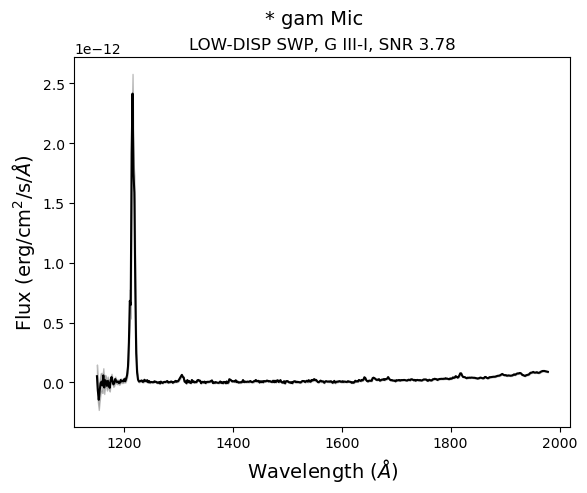

In [23]:
## Visualize spectrum

plt.tight_layout(rect=[0, 0.03, 1, 0.90])

plt.plot( wavelengths, rawflux, c='k')
plt.fill_between(wavelengths, rawflux + fluxerr, rawflux - fluxerr, alpha=0.5, color='gray')

plt.xlabel(r'Wavelength ($\AA$)', fontsize=14)
plt.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

plt.suptitle(f'{starname}', fontsize=14)
plt.title(f'{dispersion}-DISP {camera}, {spclass}, SNR {snr}')

# plt.savefig(f'{analysispath}/{swpid}_{objname}/{swpid}_raw.png', bbox_inches='tight')
# 
# plt.ylim(-.2*10**-13, .5*10**-13)
# plt.yscale('log')

## Subtract blackbody continuum

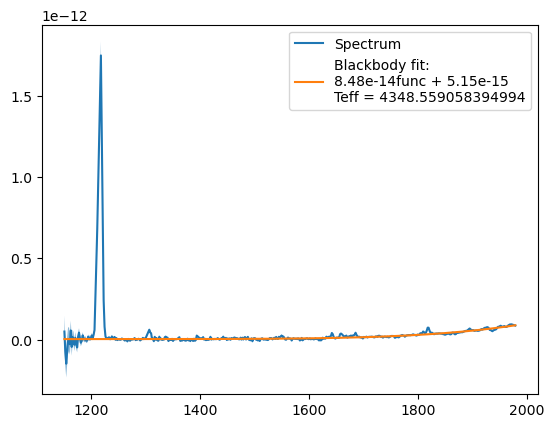

In [24]:
## Mask most features to let curve_fit see the underlying emission

diff = rawflux[1:] - rawflux[:-1]
diff = np.append(diff, 0.)
std = np.std(diff)
mask = np.logical_and((diff <= 2*std), (diff >= -2*std))

x = wavelengths[mask]
y = rawflux[mask]
yerr = fluxerr[mask]


## Fit blackbody curve to masked stellar spectrum

if fit_teff:
    popt, pcov = curve_fit(fitBB_fitTeff, x, y, p0=[Teff, 0., 0.],
                           sigma=yerr, absolute_sigma=True,
                           bounds=((3000., 0., 0.), (9000., y.max(), np.inf))) 
    
else:
    popt, pcov = curve_fit(lambda v, a, b: fitBB_fixedTeff(v, Teff, a, b), x, y, 
                           sigma=yerr, absolute_sigma=True,
                           bounds=((-np.inf, 0), (np.inf, np.inf))) 


## Plot masked spectrum and scaled blackbody curve

plt.plot(x, y, label='Spectrum')

if fit_teff:
    plt.plot(wavelengths, fitBB_fitTeff(wavelengths, popt[0], popt[1], popt[2]), 
             label=f'Blackbody fit:\n{popt[1]:0.2e}func + {popt[2]:0.2e}\nTeff = {popt[0]}')
else:
    plt.plot(wavelengths, fitBB_fixedTeff(wavelengths, Teff, popt[0], popt[1]), 
             label=f'Blackbody fit:\n{popt[0]:0.2e}func + {popt[1]:0.2e}\nTeff = {Teff}')

plt.fill_between( x, y-yerr, y+yerr, alpha=0.5 )
plt.legend()

# plt.savefig(f'{analysispath}/{swpid}_{objname}/{swpid}_blackbody.png', bbox_inches='tight')
plt.show()

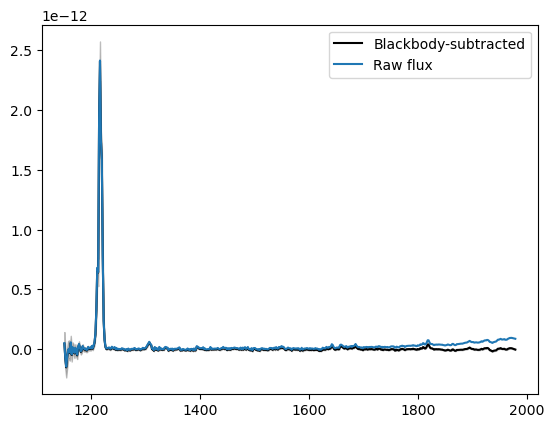

In [25]:
## Subtract BB curve

if fit_teff:
    flux = rawflux - fitBB_fitTeff(wavelengths, popt[0], popt[1], popt[2])
else:
    flux = rawflux - fitBB_fixedTeff(wavelengths, Teff, popt[0], popt[1])

## Plot BB-subtracted flux

plt.figure()
plt.plot( wavelengths, flux, color='k', label='Blackbody-subtracted' )
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')

plt.plot( wavelengths, rawflux, label='Raw flux' )
plt.legend()

Text(0.5, 1.0, 'LOW-DISP SWP, G III-I, SNR 3.78')

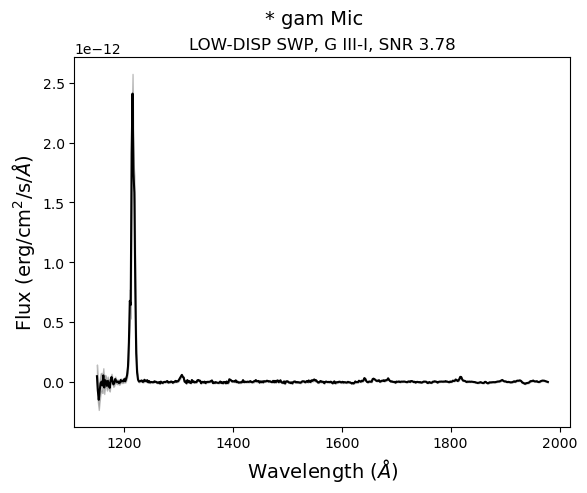

In [26]:
## Visualize BB-subtracted spectrum

# plt.tight_layout(rect=[0, 0.03, 1, 0.90])

plt.plot( wavelengths, flux, color='k', label='Blackbody-subtracted' )
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')

plt.xlabel(r'Wavelength ($\AA$)', fontsize=14)
plt.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

plt.suptitle(f'{starname}', fontsize=14)
plt.title(f'{dispersion}-DISP {camera}, {spclass}, SNR {snr}')

# plt.ylim(-.2*10**-13, .5*10**-13)
# plt.yscale('log')

In [27]:
## Save cleaned spectrum

# specDF = pd.DataFrame(data=np.array([wavelengths, flux, fluxerr]).T, columns=['Wavelengths', 'Flux', 'Fluxerr'])
# specDF.to_csv(f'{datapath}/{swpid}.csv', index=False)

# Search for lines in spectrum

First, apply a trapezoid smoothing routine to the raw spectrum. This is to reduce the likelihood of noise in the spectrum being identified as a peak, but does make the identification of the peak's central wavelength inexact. Then, use specutils to identify peaks in the spectrum.

Flux threshold: 7.246614e-15


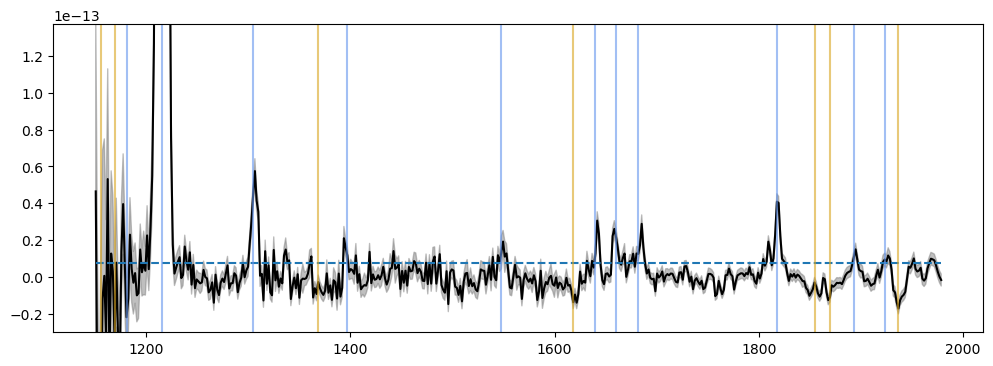

In [28]:
#####################################
## ID lines in spectrum            ##
#####################################

## Create a Spectrum1D object, subtracting smoothed spectrum
w = 5
raw_spectrum = Spectrum1D(flux = flux * (u.erg/u.cm**2/u.s/u.AA), spectral_axis = wavelengths * u.AA)
spectrum = trapezoid_smooth(raw_spectrum, w)

## Define the uncertainty of the spectrum using everything redward of the H line FIXME
noise_region = SpectralRegion(np.floor(wavelengths[0])*u.AA, np.ceil(wavelengths[-1])*u.AA)
spectrum = noise_region_uncertainty(spectrum, noise_region)


## Find lines using a noise threshold

with warnings.catch_warnings():

    warnings.simplefilter('ignore')

    thresh = np.median(np.abs(spectrum.flux.value)) + MAD(spectrum.flux.value)
#     thresh = 10*np.median(flux) # DONT USE this is for historical analysis reasons
    lines = find_lines_derivative(spectrum, thresh*(u.erg/u.cm**2/u.s/u.AA)) 
    print( 'Flux threshold:', thresh )

    
## Plot identified lines

plt.figure(figsize=(12,4))

plt.plot( wavelengths, flux, c='k')
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')
plt.hlines( thresh, wavelengths.min(), wavelengths.max(), ls='--' )

plt.ylim(0.2*flux.min(), 30*np.median(np.abs(flux)))
ymin, ymax = plt.ylim()


for l in lines:
    
    if l['line_type']=='emission':
        plt.vlines(l['line_center'].value, ymin, ymax, alpha=0.6, color='cornflowerblue')
    elif l['line_type']=='absorption':
        plt.vlines(l['line_center'].value, ymin, ymax, alpha=0.6, color='goldenrod')
    


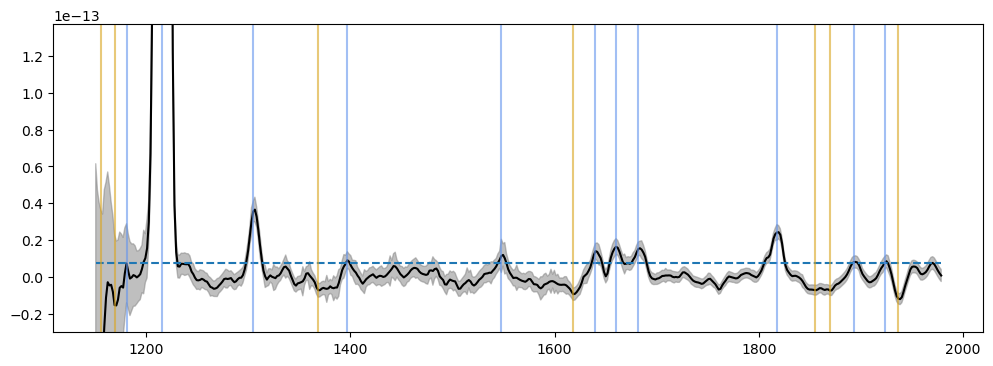

In [29]:
## Plot identified lines

plt.figure(figsize=(12,4))

plt.plot( spectrum.spectral_axis, spectrum.flux, c='k')
plt.fill_between(spectrum.spectral_axis.value, 
                 spectrum.flux.value + fluxerr, 
                 spectrum.flux.value - fluxerr, alpha=0.5, color='gray')
plt.hlines( thresh, spectrum.spectral_axis.value.min(), spectrum.spectral_axis.value.max(), ls='--' )

plt.ylim(0.2*flux.min(), 30*np.median(np.abs(flux)))
ymin, ymax = plt.ylim()


for l in lines:
    
    if l['line_type']=='emission':
        plt.vlines(l['line_center'].value, ymin, ymax, alpha=0.6, color='cornflowerblue')
    elif l['line_type']=='absorption':
        plt.vlines(l['line_center'].value, ymin, ymax, alpha=0.6, color='goldenrod')
    


## Reformat lines table

In [30]:
savelines = lines[lines['line_type']=='emission']
savelines['Peak label'] = np.round(savelines['line_center'].value).astype(int).astype(str)
savelines['Spectrum'] = np.full(len(savelines), '?')
savelines['Confident?'] = np.full(len(savelines), False)

savelines.write('/Users/isabelkain/Desktop/GALEX/data/swp54894_foundpeaks.ecsv', overwrite=True)
savelines

line_center,line_type,line_center_index,Peak label,Spectrum,Confident?
Angstrom,,,,,
float32,str10,int64,str21,str1,bool
1180.689208984375,emission,18,1181,?,False
1215.8912353515625,emission,39,1216,?,False
1304.734619140625,emission,92,1305,?,False
1396.9305419921875,emission,147,1397,?,False
1547.79638671875,emission,237,1548,?,False
1639.9923095703125,emission,292,1640,?,False
1660.10791015625,emission,304,1660,?,False
1681.8995361328125,emission,317,1682,?,False


# Fit Gaussian profile to found peaks

This fitting process is skipped in the pipeline. The data is low enough quality and the spectral lines seem to have non-gaussian profiles, so this fitting process rejected spectral lines much too aggressively.

0 True [False, True, False, True] 1 7.49309132725557 0.4151255116713334
Fit failed. No line found.
1 False [False, False, False, False] 3 0.4377677282482182 3.120561116700639
Mask check:  11 11 11
2 False [False, False, False, False] 1 1.4351381937483438 2.9133783768361377
Mask check:  11 22 22
3 False [False, False, False, False] 1 2.0661729386226853 1.5004414850665988
Mask check:  5 27 27
4 False [False, False, False, False] 1 1.360845249953627 3.0560462408234668
Mask check:  11 38 38
5 False [False, False, False, False] 3 2.089146020805174 1.6572231024027702
Mask check:  6 44 44
6 False [False, False, False, False] 1 0.7471897989594254 2.878236203255271
Mask check:  10 54 54
7 False [False, False, False, False] 1 1.3947418793402449 5.00539473462918
Mask check:  18 72 72
8 False [False, False, False, False] 1 0.7869965092254461 2.8029651179235806
Mask check:  10 82 82
9 False [False, False, False, False] 1 1.3289057928168404 2.71783331700719
Mask check:  10 92 92
10 False [False, Fal

line_center,line_type,line_center_index,peak_fit,peak_std
Angstrom,,,Angstrom,Angstrom
float32,str10,int64,float64,float64
1215.8912353515625,emission,39,1216.3290030798107,3.120561116700639
1304.734619140625,emission,92,1306.1697573343733,2.9133783768361377
1396.9305419921875,emission,147,1394.8643690535648,1.5004414850665988
1547.79638671875,emission,237,1549.1572319687036,3.0560462408234668
1639.9923095703125,emission,292,1642.0814555911177,1.6572231024027702
1660.10791015625,emission,304,1659.3607203572906,2.878236203255271
1681.8995361328125,emission,317,1683.2942780121527,5.00539473462918
1817.678955078125,emission,398,1818.4659515873504,2.8029651179235806


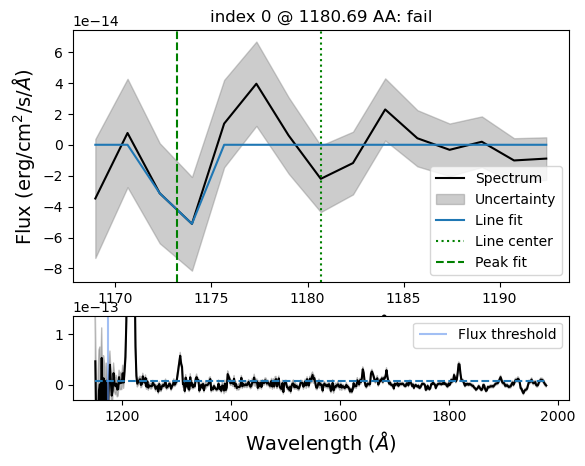

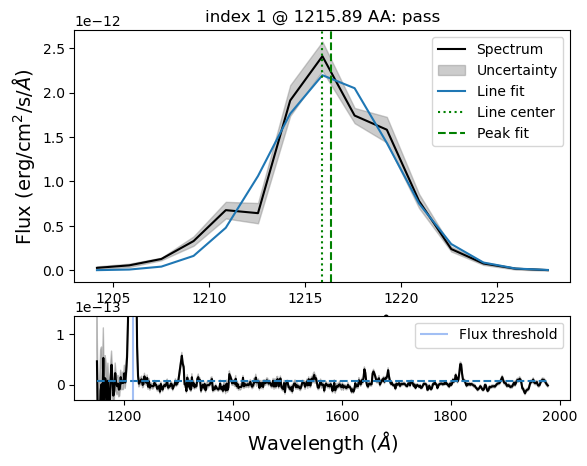

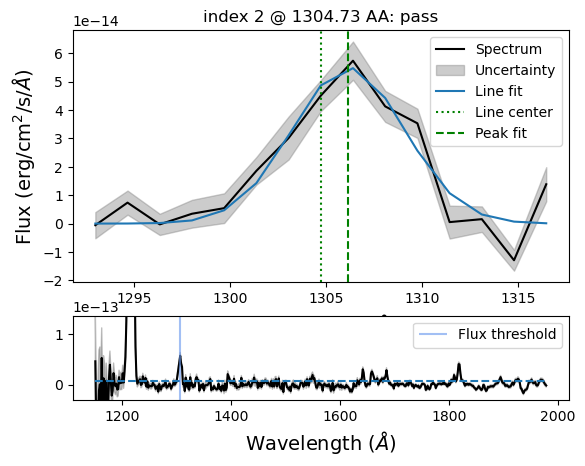

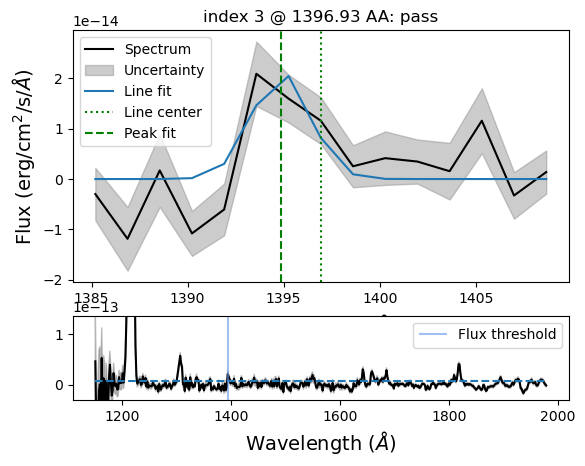

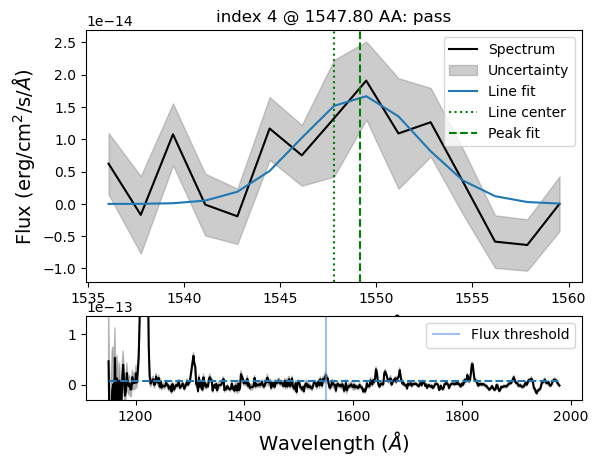

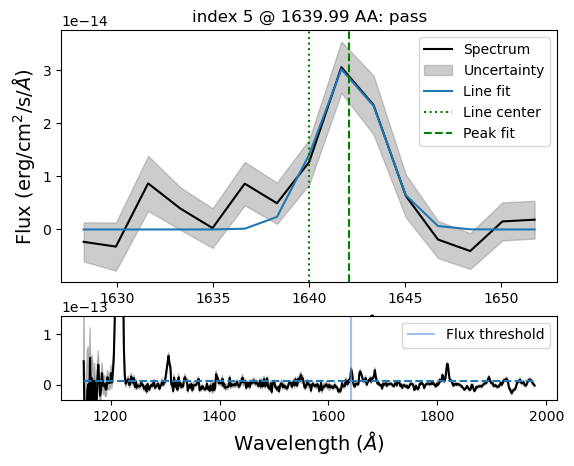

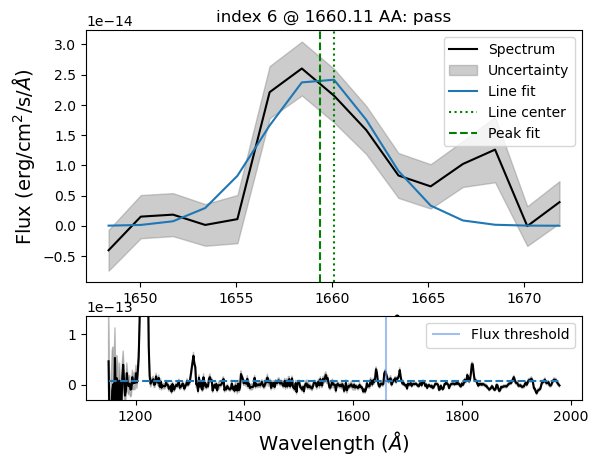

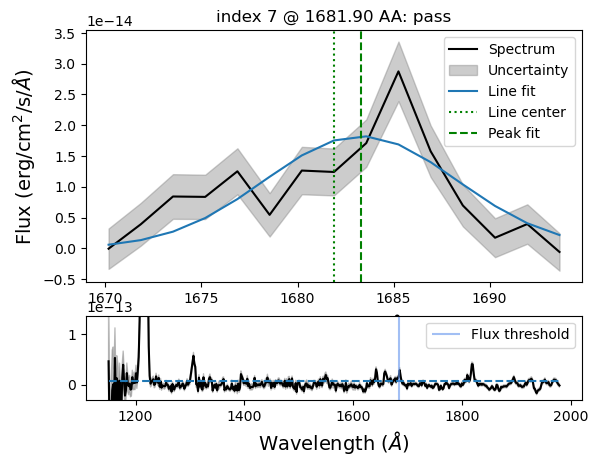

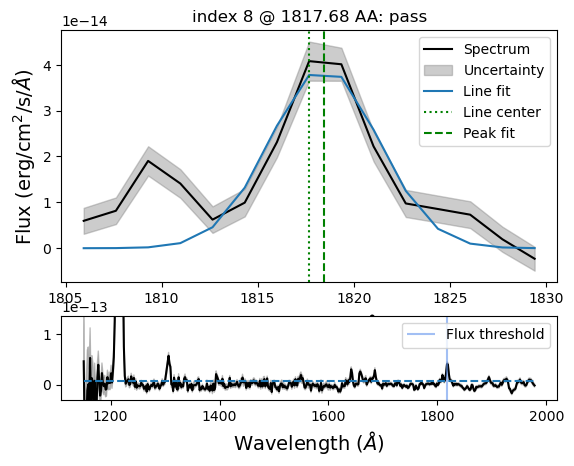

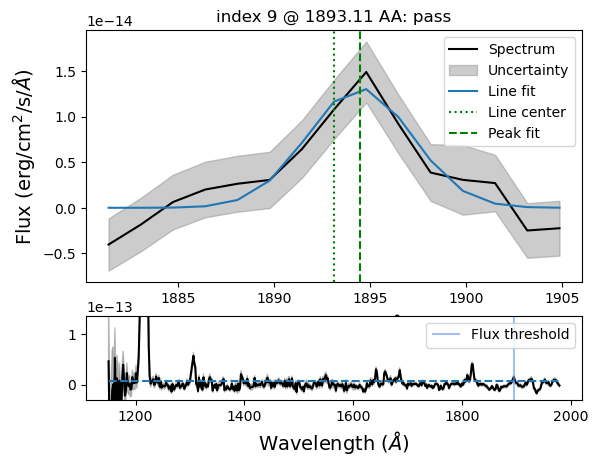

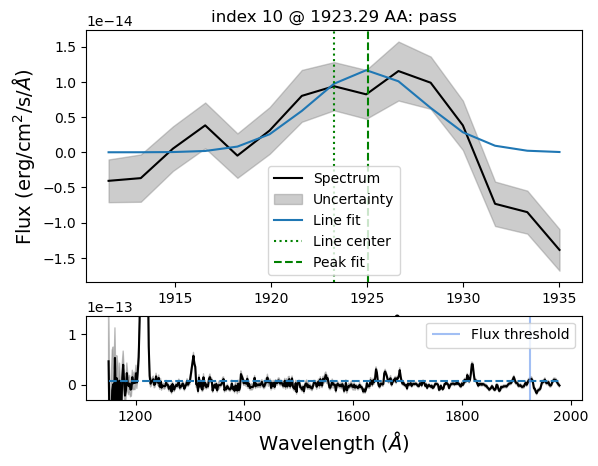

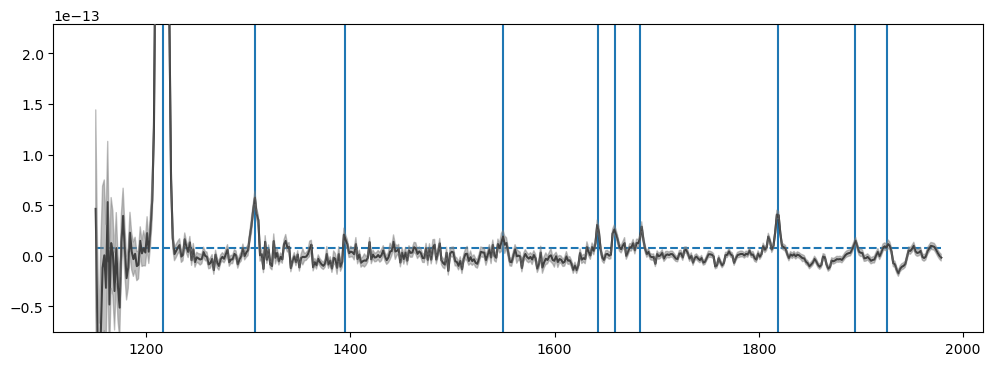

In [31]:
#####################################
## Fit Gaussian to line candidates ##
#####################################

'''
Lots of variables in here with related meanings.

spectrum:
    Spectrum1D object containing smoothed version of original data.
raw_spectrum:
    Spectrum1D object containing original data.
search_spectrum:
    Spectrum1D object containing a copy of spectrum, with already fitted lines masked out
window:
    Spectrum1D object, subset of spectrum (smoothed version) isolated around line being fitted.
x, y, yerr:
    unitless arrays containing x (wavelength), y (flux) and yerr (flux error) data from window
y_fit:
    astropy Quantity array containing Gaussian fit to isolated line
'''

## Create new columns in lines

lines['peak_fit'] = np.zeros(len(lines)) * u.AA
lines['peak_std'] = np.zeros(len(lines)) * u.AA


## Make copy of spectrum to mask lines as we fit them

search_spectrum = Spectrum1D(flux=raw_spectrum.flux, spectral_axis=raw_spectrum.spectral_axis) # use unsmoothed because smoothing shifts peak locations enough to be troublesome
search_spectrum.mask = [False]*len(search_spectrum.data)

###############################
## Fit Gaussian to each line ##
###############################

for i, cen in enumerate(lines[lines['line_type']=='emission']['line_center'].value):
    
    ## Set window around line center
    margin = 12. # AA
    ulim = cen - margin
    hlim = cen + margin
    
    # have to do this stupid shit because Spectrum1D doesn't ACTUALLY mask its data
    xmask = search_spectrum.spectral_axis.value[~search_spectrum.mask] 
    ymask = search_spectrum.flux.value[~search_spectrum.mask]
    yerrmask = fluxerr[~search_spectrum.mask]

    # Trim x and y arrays down to window around line
    trim = (xmask >= ulim) & (xmask < hlim)
    x = xmask[trim]
    y = ymask[trim]
    yerr = yerrmask[trim]

    window = Spectrum1D(flux=y*(u.erg/u.cm**2/u.s/u.AA), spectral_axis=x*u.AA)
    
    ## Initialize Gaussian model and fitter
    fitter = LevMarLSQFitter()
    g_init = models.Gaussian1D(amplitude=y.max() * (u.erg/u.cm**2/u.s/u.AA), 
                               mean=cen * u.AA, 
                               stddev=3.*u.AA)
    
    ## Fit model to window around line 
    g_fit = fit_lines(window, g_init, fitter=fitter)
    y_fit = g_fit(x * u.AA)


    #########################
    ## Acceptance criteria ##
    #########################
    
    ## Check if fit succeeded FIXME: rejecting everything after introducing smoothed input spectrum

    crit = [fitter.fit_info['ierr'] not in [1, 2, 3, 4], 
            np.abs( cen - g_fit.mean.value ) > 3., 
            g_fit.stddev.value <= 0.01, g_fit.mean.value < 1200.]
#             g_fit.stddev.value >= 4.0] ## stddev varies a lot with line type, unreliable metric
    fail = np.any(crit)
    print(i, fail, crit, fitter.fit_info['ierr'], np.abs( cen - g_fit.mean.value ), g_fit.stddev.value)

    if fail:
        print('Fit failed. No line found.')

    else:

        ## Mask line in search_spectrum
        line_center = g_fit.mean.value # AA
        line_stddev = g_fit.stddev.value
        
        line_lowlim = line_center - 3*line_stddev
        line_uplim = line_center + 3*line_stddev

        hideline = (search_spectrum.spectral_axis.value >= line_lowlim) & (search_spectrum.spectral_axis.value < line_uplim)
        oldmask = search_spectrum.mask
        
        search_spectrum.mask = np.logical_or(hideline, oldmask)
        print('Mask check: ', np.sum(hideline), np.sum(np.logical_or(hideline, oldmask)), np.sum(search_spectrum.mask) )

        
        ## Save peak wavelength
        j = np.argmin(np.abs(lines['line_center'] - cen * u.AA))
        lines[j]['peak_fit'] = g_fit.mean.value * u.AA
        lines[j]['peak_std'] = g_fit.stddev.value * u.AA

        
    #########################
    ## Plot results        ##
    #########################
    
    diagnostic_plots = True
    
    if diagnostic_plots:
        
        if fail: status = 'fail'
        else: status = 'pass'

        fig = plt.figure()
        gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1))

        # Plot isolated line and fit
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])

        ax1.plot( x, y, c='k', label='Spectrum' )
        ax1.fill_between( x, y-yerr, y+yerr, alpha=0.4, color='gray', label='Uncertainty' )
        ax1.plot( x, y_fit, label='Line fit' )
        ymin, ymax = ax1.set_ylim()

        ax1.vlines(cen, ymin, ymax, ls=':', color='g', label='Line center' )
        ax1.vlines(g_fit.mean.value, ymin, ymax, ls='--', color='g', label='Peak fit' )

        ax1.set_title(f'index {i} @ {cen:0.2f} AA: {status}')
        ax1.legend()
        ax1.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
        ax1.set_ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

        # Plot full spectrum with line annotated
        ax2.plot( wavelengths, flux, c='k' )
        ax2.fill_between( wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray' )
        ax2.hlines( thresh, wavelengths.min(), wavelengths.max(), ls='--' )
        
        ax2.set_ylim(0.2*flux.min(), 30*np.median(np.abs(flux)))
        ymin, ymax = ax2.set_ylim()

        ax2.vlines(g_fit.mean.value, ymin, ymax, alpha=0.6, color='cornflowerblue', label='Flux threshold')
        ax2.legend()
        ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)


        ## Save figure
#         if not os.path.exists(f'{analysispath}/{swpid}_{objname}/linefit_plots'):
#             os.mkdir(f'{analysispath}/{swpid}_{objname}/linefit_plots')
        
#         plt.savefig(f'{analysispath}/{swpid}_{objname}/linefit_plots/{i}_{round(cen)}_{status}.png')
#         plt.close()
        
    
    
## Record successfully fit lines
goodlines = lines[lines['peak_fit']!=0.0*u.AA]
display(goodlines)


#########################
## Plot whole spectrum ##
#########################

plt.figure(figsize=(12,4))
plt.plot(wavelengths, flux, color='k', zorder=5)
plt.fill_between(wavelengths, flux-fluxerr, flux+fluxerr, alpha=0.5, color='gray', zorder=5)
plt.hlines( thresh, wavelengths.min(), wavelengths.max(), ls='--' )

plt.ylim(0.5*flux.min(), 50*np.median(np.abs(flux)))
ymin, ymax = plt.ylim()

for line in goodlines:
    plt.vlines(line['peak_fit'].value, ymin, ymax)
    
    
## Save figure
# if not os.path.exists(f'{analysispath}/{swpid}_{objname}/linefit_plots'):
#     os.mkdir(f'{analysispath}/{swpid}_{objname}/linefit_plots')

# plt.savefig(f'{analysispath}/{swpid}_{objname}/linefit_plots/all_lines.png')


## Save table of found lines
columns=['NIST peak', 'Measured peak', 'Stddev', 'Peak label', 'Spectrum', 'Confident?']
rows = np.array([goodlines['line_center'], goodlines['peak_fit'], 
                 goodlines['peak_std'], np.round(goodlines['line_center'].value).astype(int),
                 np.full(len(goodlines), '?'), np.zeros(len(goodlines))]).T

linestable = pd.DataFrame(columns=columns, data=rows)
# linestable.to_csv(f'{analysispath}/{swpid}_{objname}/linestable.csv', index=False)
    

In [32]:
display(goodlines)
display(linestable)

line_center,line_type,line_center_index,peak_fit,peak_std
Angstrom,,,Angstrom,Angstrom
float32,str10,int64,float64,float64
1215.8912353515625,emission,39,1216.3290030798107,3.120561116700639
1304.734619140625,emission,92,1306.1697573343733,2.9133783768361377
1396.9305419921875,emission,147,1394.8643690535648,1.5004414850665988
1547.79638671875,emission,237,1549.1572319687036,3.0560462408234668
1639.9923095703125,emission,292,1642.0814555911177,1.6572231024027702
1660.10791015625,emission,304,1659.3607203572906,2.878236203255271
1681.8995361328125,emission,317,1683.2942780121527,5.00539473462918
1817.678955078125,emission,398,1818.4659515873504,2.8029651179235806


,NIST peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,1215.8912,1216.3290030798107,3.120561116700639,1216,?,0.0
1,1304.7346,1306.1697573343733,2.9133783768361377,1305,?,0.0
2,1396.9305,1394.8643690535648,1.5004414850665988,1397,?,0.0
3,1547.7964,1549.1572319687036,3.0560462408234668,1548,?,0.0
4,1639.9923,1642.0814555911177,1.6572231024027702,1640,?,0.0
5,1660.1079,1659.3607203572906,2.878236203255271,1660,?,0.0
6,1681.8995,1683.2942780121527,5.00539473462918,1682,?,0.0
7,1817.679,1818.4659515873504,2.8029651179235806,1818,?,0.0
8,1893.1119,1894.4408442693793,2.71783331700719,1893,?,0.0
9,1923.2852,1925.0516195632006,2.939783604973374,1923,?,0.0


# Search NIST for matching lines

For each peak that has been identified in the spectrum, query NIST for atomic emission lines within some margin of the peak wavelength. The results of this query is loaded into a Pandas DF and plotted over the peak to visualize results. The way the NIST lines are overplotted is tweakable to emphasize certain things -- currently it's set so that spectra with a small number of lines are plotted with higher opacity (& thus look more visually apparent).

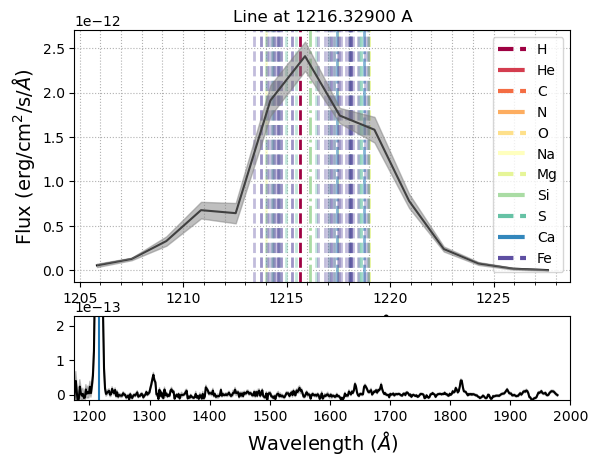

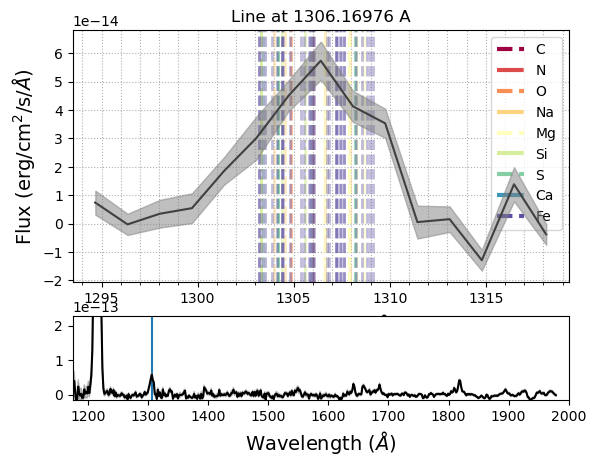

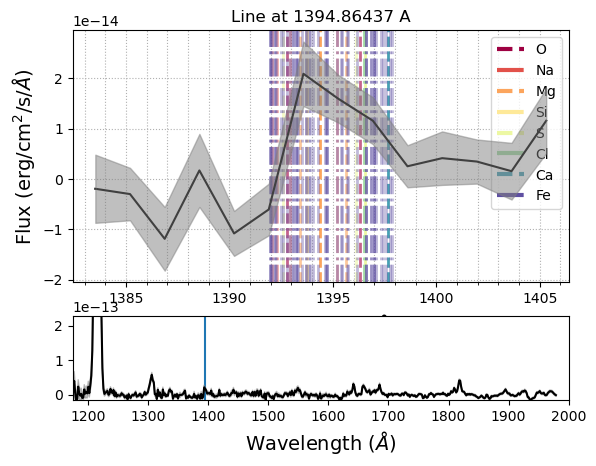

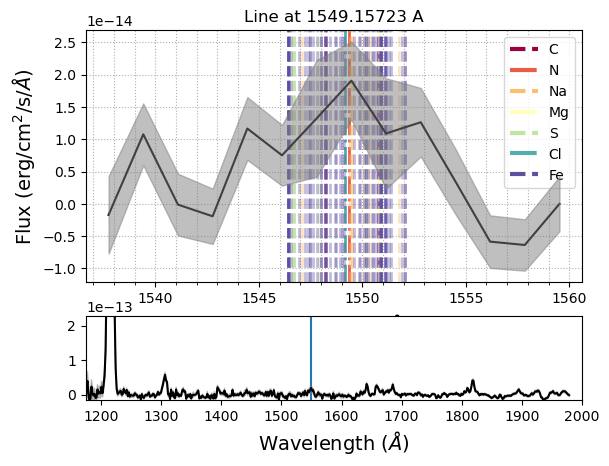

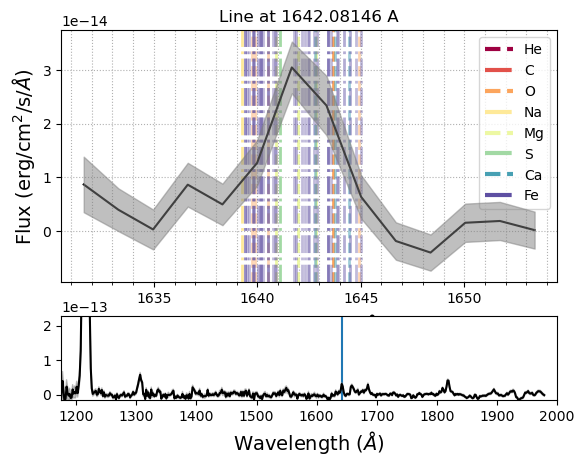

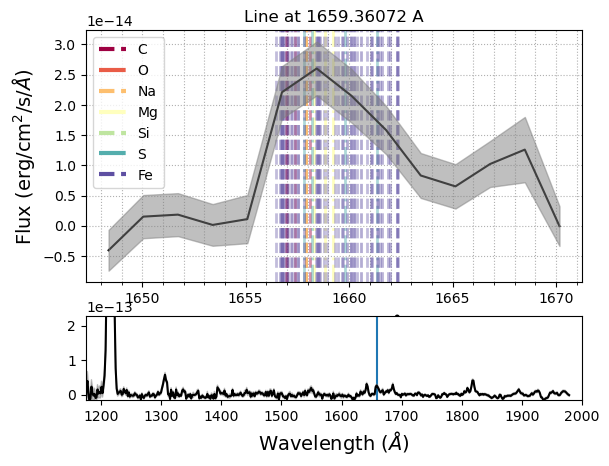

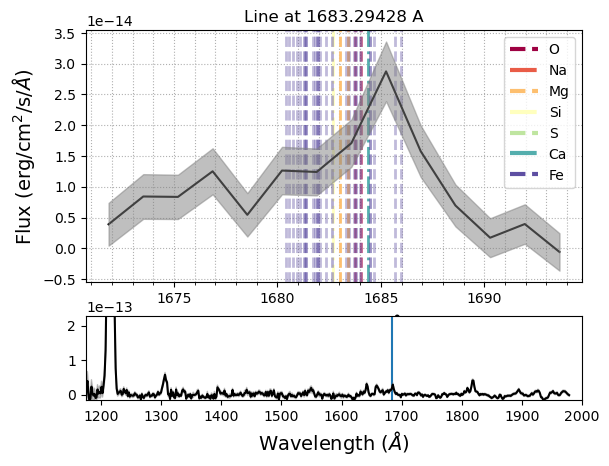

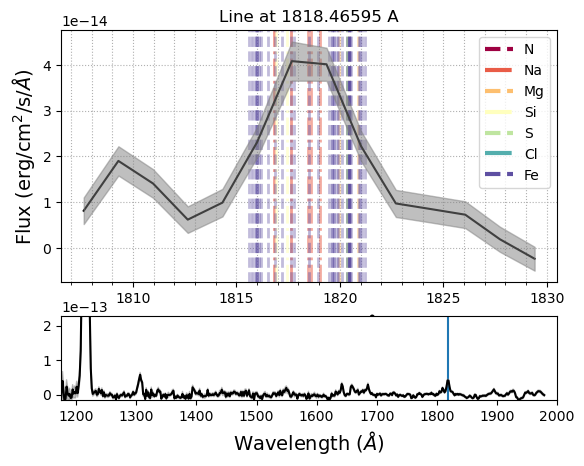

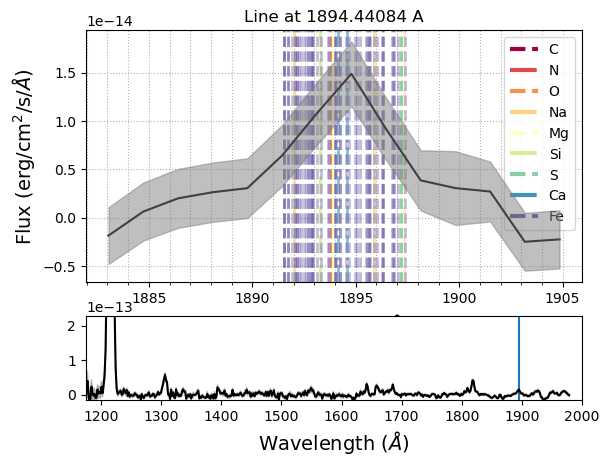

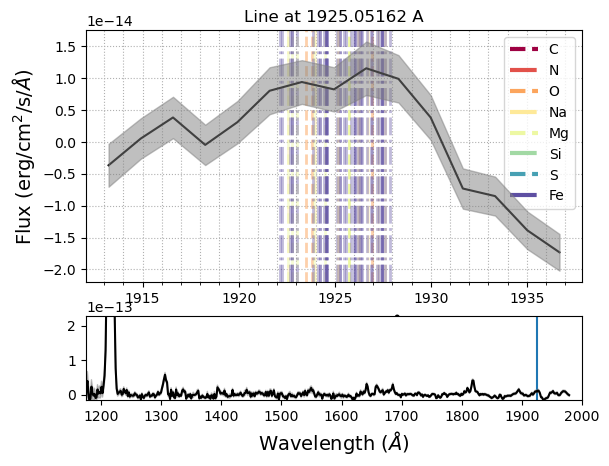

In [143]:
## Iterate through successfully identified lines

for i in range(len(linestable)):
    
    line = linestable.loc[i, :] ## Line is current row in linestable

    ## Set window around peak based on best-fit mean and stddev values

    plotmargin = 12.
    peak = float(line['Measured peak'])

    if peak==0:
        peak = float(line['Approx peak']) # peak hasn't been fit yet

    ulim = peak - plotmargin
    hlim = peak + plotmargin

    NISTmargin = 3.
    NISTulim = peak - NISTmargin
    NISThlim = peak + NISTmargin

    trim = (wavelengths >= ulim) & (wavelengths <= hlim)
    x = wavelengths[trim]
    y = flux[trim]
    yerr = fluxerr[trim]


    #################################
    ## Query NIST for nearby lines ##
    #################################

    NISTresults = pd.DataFrame(columns=['Spectrum', 'Observed', 'Rel.', 'Acc.'])
    elements = ['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Cl', 'Ca', 'Fe']
    found_el = []

    for i, el in enumerate(elements):

        try:
            result = Nist.query(NISTulim * u.AA, NISThlim * u.AA, linename=f"{el}")

        except:
#             print(f'No result for {el}')
            continue

        ## Count number of elements with matching lines
        found_el.append(i)

        ## Save line information

        try:    spec = result['Spectrum'].data
        except: spec = np.array([f'{el} I']*len(result))  # If NIST result has no Spectrum column, then only one ionization level exists

        newresult = pd.DataFrame( data={'Spectrum':spec, 
                                        'Observed':result['Observed'].data, 
                                        'Rel.':result['Rel.'].data.astype(str), 
                                        'Acc.':result['Acc.'].data} )

        newresult.dropna(axis=0, subset=['Observed', 'Rel.'], inplace=True)
        NISTresults = pd.concat([NISTresults, newresult], axis=0, ignore_index=True)


    ## Reformat relative intensities column (strip keyword info)
    NISTresults['Rel.'] = NISTresults['Rel.'].str.replace('[,()\/*a-zA-Z?:]', '', regex=True).str.strip()
    NISTresults['Rel.'] = NISTresults['Rel.'].str.replace('^\s*$', '0', regex=True).str.strip()
    NISTresults['Rel.'] = NISTresults['Rel.'].astype(float)

    #     display(NISTresults)

    ## Assess most likely line -- jk data is too shitty to do this
    # xyz


    #######################
    ## Visualize results ##
    #######################

    fig = plt.figure()
    gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1))

    ax1 = fig.add_subplot(gs[0]) # peak + NIST
    ax2 = fig.add_subplot(gs[1]) # full spectrum with line annotated


    ## From list of indices, which elements had matching lines?

    ID_elements = [elements[i] for i in found_el]


    ## Set colormap, opacities for plotting

    cmap = mpl.colormaps['Spectral'] # gist_rainbow is clearer but uglier
    colors = cmap(np.linspace(0,1,len(ID_elements)))
    maxint = NISTresults['Rel.'].max()

    for i, el in enumerate(ID_elements):

        ## Isolate lines attributed to l, plot each one
        el_lines = NISTresults.loc[NISTresults['Spectrum'].str.contains(f'{el} ')]

        if i%2==0: ls = '--'
        else: ls = '-.'

        for j, l in el_lines.iterrows():

            opacity = np.exp(1 / np.sum(l['Spectrum'] == NISTresults['Spectrum'])) / np.exp(1)
            ax1.axvline(l['Observed'], alpha=opacity, ls=ls, lw=2, color=colors[i]) # alpha=(float(l['Rel.'])/maxint)**.1

    ## Save legend handles

    handles = []

    for i in range(0, len(ID_elements)):

        if i%2==0: ls = '--'
        else: ls = '-.'

        handles = np.append( handles, Line2D([0],[0],color=colors[i], lw=3, ls=ls, label=f'{ID_elements[i]}') )


    ## Finish plot

    ax1.plot( x, y, c='k', zorder=10 )
    ax1.fill_between( x, y-yerr, y+yerr, alpha=0.5, color='gray', zorder=10 )

    # Plot full spectrum with line annotated
    ax2.plot( wavelengths, flux, c='k' )
    ax2.fill_between( wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray' )

    ax2.set_ylim(0.1*flux.min(), 50*np.median(np.abs(flux)))
    ax2.axvline(peak, zorder=0)

    ax1.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
    ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
    ax1.set_ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

    ax1.legend(handles, ID_elements)
    ax1.grid(True, which='both', ls=':')
    ax1.set_title(f'Line at {peak:0.5f} A')
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax2.set_xlim(1175, 2000)

#     ## Save figure
#     if not os.path.exists(f'{analysispath}/{swpid}_{objname}/lineID_plots'):
#         os.mkdir(f'{analysispath}/{swpid}_{objname}/lineID_plots')

#     plt.savefig(f'{analysispath}/{swpid}_{objname}/lineID_plots/{round(peak)}.png')
    
#     ## Save table
#     if not os.path.exists(f'{analysispath}/{swpid}_{objname}/lineID_tables'):
#         os.mkdir(f'{analysispath}/{swpid}_{objname}/lineID_tables')

#     NISTresults.to_csv(f'{analysispath}/{swpid}_{objname}/lineID_tables/{round(peak)}.csv', index=False)
    
    # plt.close()


## Build template spectra

In [177]:
def build_template_spectra(swpid, objname, analysispath, wav_min, wav_max):
    '''
    Compiles list of all candidate emission lines matched to any lines in IUE spectrum. 
    Builds a "template spectrum" for each element and transition matched by the pipeline.
    
    Inputs:
    
    Returns:
    nothing, but saves "template spectrum" to csv.
    '''

    ## Initialize DF to collect all emission line candidates matched with lines in IUE spectra
    allspectra = pd.DataFrame()

    ## Load table of all emission line candidates matched to each individual IUE spectral line
    lineIDs = glob.glob(f'{analysispath}/{swpid}_{objname}/lineID_tables/*.csv')
    peaklabels = [lineIDs[i].split('/')[-1].strip('.csv') for i in range(len(lineIDs))]


    for pl in peaklabels:

        linematches = pd.read_csv(f'{analysispath}/{swpid}_{objname}/lineID_tables/{pl}.csv')    ## UN0 fine  
        allspectra = pd.concat([allspectra, linematches], axis=0, ignore_index=True) ## UN0 bad

        try: allspectra.drop(columns=['Unnamed: 0'], inplace=True)
        except: pass
        
        
    if len(allspectra)==0: ## no lines in spectrum, skip
        return 0
    

    for spec in allspectra['Spectrum'].unique():

        ## Build DF of atomic lines from one element identified in this stellar spectrum by pipeline
        speclines = allspectra[allspectra['Spectrum']==spec].reset_index(drop=True)
        speclines['Pipeline matched'] = [True]*len(speclines)

        ## Query NIST for all lines from current spectrum
        ask = Nist.query(wav_min * u.AA, wav_max * u.AA, linename=f"{spec}") 

        result = pd.DataFrame( data={'Spectrum':[spec]*len(ask), 
                                     'Observed':ask['Observed'].data, 
                                     'Rel.':ask['Rel.'].data.astype(str), 
                                     'Acc.':ask['Acc.'].data} )

        result.dropna(axis=0, subset=['Observed', 'Rel.'], inplace=True)

        ## Reformat relative intensities column (strip keyword info)
        result['Rel.'] = result['Rel.'].str.replace('[,()\/*a-zA-Z?:]', '', regex=True).str.strip()
        result['Rel.'] = result['Rel.'].str.replace('^\s*$', '0', regex=True).str.strip()
        result['Rel.'] = result['Rel.'].astype(float)
        result['Pipeline matched'] = [False]*len(result)

        ## Drop lines in result that are weaker than weakest line found by pipeline ##FIXME hey this kind of sucks because it's RELATIVE intensity and NIST's documentation on what that means is uninformative
        result[ result['Rel.'] >= np.min(speclines['Rel.']) ].reset_index(drop=True)

        ## Combine speclines (lines found by pipeline attributed to single element) with result (all lines from the element with relative intensity greater than weakest line found by pipeline)
        fullspectrumlines = pd.concat([speclines, result], axis=0, ignore_index=True)

        ## Drop duplicate rows, where line is recognized by pipeline AND returned by NIST query
        fullspectrumlines = fullspectrumlines.drop_duplicates(subset=['Spectrum', 'Observed', 'Rel.', 'Acc.'], ignore_index=True)

        ## Save template spectrum
        fullspectrumlines.to_csv(f'{analysispath}/{swpid}_{objname}/lineID_tables/{spec}_template.csv', index=False)
        
    return 0

In [179]:
rows = [table[i] for i in range(len(table))]

for i, row in enumerate(tqdm(rows)):
    
    ## Grab and reformat object name
    swpid = row['obs_id']
    starname = row['main_id']
    objname = starname.replace(' ','')
    subfolder = f'{swpid}_{objname}' # e.g. swp55292_HD2454

    ## Read in saved spectrum
    spectrum = pd.read_csv(f'{datapath}/{swpid}.csv')
    wavelengths = spectrum['Wavelengths'].values
    flux = spectrum['Flux'].values
    fluxerr = spectrum['Fluxerr'].values
    
    wav_min = wavelengths[0]
    wav_max = wavelengths[-1]

#     ## Read in linestable
#     linestable = pd.read_csv(f'{analysispath}/{swpid}_{objname}/linestable.csv')

    build_template_spectra(swpid, objname, analysispath, wav_min, wav_max)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [20:07<00:00, 10.69s/it]


In [229]:
from pipeline import queryNIST

rows = [table[i] for i in range(len(table))]

for i, row in enumerate(tqdm(rows)):
    
    ## Grab and reformat object name
    swpid = row['obs_id']
    starname = row['main_id']
    objname = starname.replace(' ','')
    subfolder = f'{swpid}_{objname}' # e.g. swp55292_HD2454

    ## Read in saved spectrum
    spectrum = pd.read_csv(f'{datapath}/{swpid}.csv')
    wavelengths = spectrum['Wavelengths'].values
    flux = spectrum['Flux'].values
    fluxerr = spectrum['Fluxerr'].values
    
    wav_min = wavelengths[0]
    wav_max = wavelengths[-1]

    ## Read in linestable
    linestable = pd.read_csv(f'{analysispath}/{swpid}_{objname}/linestable.csv')

    ## Re-query NIST
    queryNIST(linestable, wavelengths, flux, fluxerr, swpid, objname)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [04:03<00:00,  2.15s/it]


## Plot templates onto IUE spectrum

In [185]:
## Load template
template = pd.read_csv('/Users/isabelkain/Desktop/GALEX/analysis/swp54894_*gamMic/lineID_tables/O V_template.csv')

template

,Spectrum,Observed,Rel.,Acc.,Pipeline matched
0,O V,1643.680,301050.0,NaN,True
1,O V,1371.292,604000.0,A+,True
2,O V,1506.720,106000.0,NaN,True
3,O V,1707.996,106000.0,B,True
4,O V,1371.292,640.0,A+,True
5,O V,1506.720,160.0,NaN,True
6,O V,1643.680,315.0,NaN,True
7,O V,1707.996,160.0,B,True


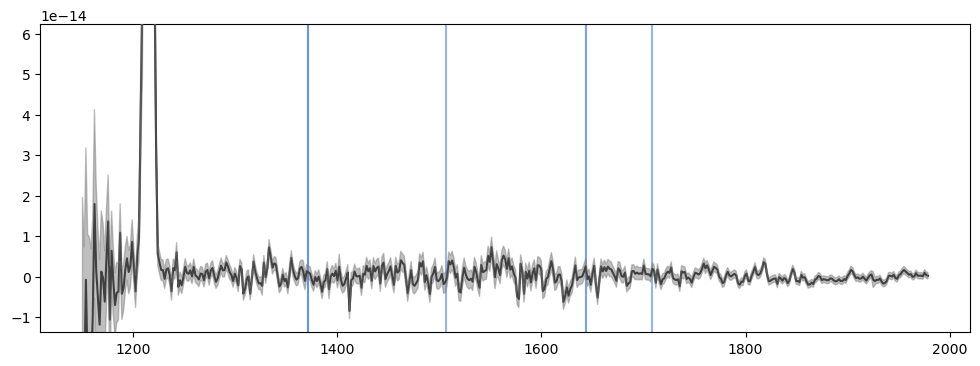

In [217]:
## Load template
template = pd.read_csv('/Users/isabelkain/Desktop/GALEX/analysis/swp54894_*gamMic/lineID_tables/O V_template.csv')

## Plot IUE spectrum
plt.figure(figsize=(12,4))
plt.plot(wavelengths, flux, color='k', zorder=5)
plt.fill_between(wavelengths, flux-fluxerr, flux+fluxerr, alpha=0.5, color='gray', zorder=5)

plt.ylim(0.5*flux.min(), 50*np.median(np.abs(flux)))

## Plot lines identified by pipeline
for i in range(len(template)):
    
    if template.loc[i, 'Pipeline matched']==True: ls = '-'
    else: ls = ':'
        
    plt.axvline(template.loc[i, 'Observed'], ls=ls, color='cornflowerblue', 
                alpha=(float(template.loc[i, 'Rel.'])/template['Rel.'].max())**.25)


In [197]:
test = np.array(['green']*len(template))

test[~template['Pipeline matched'].values] = 'red'

test

array(['green', 'red'], dtype='<U5')

In [212]:
from matplotlib.colors import rgb2hex
import matplotlib as mpl

cmap = plt.get_cmap('turbo')(np.linspace(0.0, 1.0, len(elements)))
colors = [rgb2hex(cmap[i]) for i in range(len(elements))]


['#30123b',
 '#4454c3',
 '#448ffe',
 '#20c7df',
 '#2aefa1',
 '#7dff56',
 '#c1f334',
 '#f1cb3a',
 '#fe9029',
 '#ea4e0d',
 '#be2102',
 '#7a0403']

In [226]:
# active = [21, 26, 8]
# tmplt = glob.glob(f'{analysispath}/swp54894_*gamMic/lineID_tables/*template.csv')
# elements = [tmplt[i].split('/')[-1].split('_')[0] for i in range(len(tmplt))]

active_elements = [elements[i] for i in active]

selected_elements = pd.DataFrame(data=active_elements, columns='Elements')
selected_elements.to_csv(f'{analysispath}/{swpid}_{objname}/lineID_tables/selected_elements.csv', index=False)

['Na III', 'Na II', 'Na IV', 'Cl II', 'S I', 'Cl IV', 'Fe IV', 'Fe II', 'C IV', 'Cl III', 'Si II', 'N I', 'S IV', 'Ca II', 'S II', 'N V', 'Si III', 'O V', 'H I', 'Mg II', 'Si I', 'O I', 'Mg IV', 'Mg III', 'Ca III', 'O II', 'C I', 'Fe III', 'Fe V'] [21, 26, 8]


['O I', 'C I', 'C IV']

In [227]:
result = ', '.join(active_elements)

'O I, C I, C IV'

In [216]:
template

,Spectrum,Observed,Rel.,Acc.,Pipeline matched
0,H I,1215.6701,8.040000e+11,AAA,True
1,H I,1215.6701,8.400000e+05,AAA,False
